**ORIE 5129: e-Logistics Case 3**  
*Due Apr 28, 2021 (Ext. Apr 30)*  
Connor Young (cey23), Virginia Lu (vl239)  

# Objective

Citi Bike operates by providing on-demand bicycle access to New Yorkers via stations located around the city where bikes can be rented and returned to. This is generally an extremely convenient system, with many stations located all around the city. However, there are limitations to its efficacy, one of which is something called "outages". An outage occurs if a station is unable to meet a rider's demand, which can happen in two ways. First, a prospective rider may show up to a station looking to initiate a ride and find that there are no available bikes there. Alternatively, an active rider may bring their bike to a station to return it and find the station completely full, meaning there is nowhere to dock their bike. These create issues for the user and limit the potential revenue that Citi Bike could attain if no outages ever occurred, so it is in their best interest in multiple ways to avoid them.

Our objective in this case is to minimize outages for Citi Bike by using modeling to determine the optimal number and allocation of bikes at each station around New York City. This also informs the number of bikes that should typically be moved each day to keep the system in balance. Related to this, we will explore how points may be assigned to Bike Angels who help reduce station outages by moving bikes to and from certain stations in exchange for rewards. We will do this by estimating the value of adding or removing one bike during midday for each station and determining which gives the better system improvement. 

# Assumptions and Data

We use two main datasets for this analysis, both from the Citi Bike website. The datasets are the July 2019 Citi Bike usage data for NYC and Citi Bike's station information data. The Citi Bike usage data provides information for every trip taken in July 2019, including the date they were taken, the start and stop times, and the corresponding station names. The station information dataset provides information on all the current in-service bike stations in NYC, such as the capacity at each station and the location in latitude and longitude. There are a total of 1422 stations listed.  

#### Data Cleaning  

- The station information file is most likely up-to-date, so some stations listed in the July 2019 usage data might have been removed since then. Thus, we removed all the trips whose start or stop station cannot be found in the station information file or is NaN.
- We focused on modeling the bike sharing system for weekdays, removing weekends due to potentially significant variations in user behavior (different schedules and routines).
- We modeled all weekdays as being equivalent to each other.
- We assumed that the number of rides from midnight to 5am is negligible and thus removed them as well.  

*Note: Further assumptions addressed later in the Bike Angels Model below.*

# Calculations

#### Biker Arrival Rates ($\mu$)  

At station $i$, there is a constant arrival rate $\mu_t(i)$ of users taking a bike in the $t^{th}$ hour of the day starting at 5 am and ending at midnight on weekdays. For example, $\mu_0(i)$ is the arrival rate in the hour 5-6 am at station $i$, $\mu_1(i)$ is the arrival rate in the hour 6-7 am at station $i$, and so forth to $\mu_{18}(i)$ the arrival rate during 11 pm-midnight at station $i$.
We estimated these 19 numbers for each station $i$ by counting from the data the number of rides initiated in the $t^{th}$ hour from station $i$, and averaged the number across all the weekdays in the month (there are a total of 23 weekdays in July 2019).

#### Transition Probabilities  

Next, we calculated the transition probability matrices for all 19 hours, giving 19 unique matrices. Each matrix has dimension $(i,j)=$ (1422, 1422) and represents the probability of a rider traveling from station $i$ to station $j$. In other words, for each hour $t$ the transition probabilities $p_t(i, j) =$ Pr(destination station is $j$ | a ride leaves station $i$ in hour $t$). We computed these probabilities as the fraction of rides beginning at station $i$ in time $t$ that go to station $j$. To validate our numbers, we checked that each row sums to 1 as it should. If we found that no rides originate from station $i$ in hour $t$ then we had set $p_t(i, i) = 1$ and $p_t(i, j)=0$ for $j$ not equal to $i$.

#### Bike Returning Rates ($\lambda$)  

Lastly for data calculations, we calculated for each hour $t$ and all stations $i$ the arrival rate of riders returning bikes to station $i$. So similarly to $\mu$, there is a constant arrival rate of bikers returning bikes $\lambda_0(i)$ during the hour 5-6 am on weekdays, a potentially different constant value $\lambda_1(i)$ during 6-7 am on weekdays, and so forth to $\lambda_18(i)$ at station $i$. We estimated these 19 numbers for each station $i$ by calculating: 

> $\lambda_t(j) = \sum\limits_{i=1}^{1422}(\mu_t(i)*p_t(i,j))$

Here, $\lambda_t(j)$ represents the average number of riders returning bikes per hour in the $t^{th}$ hour of the week to station $j$.

# Bike Sharing Model

#### Creating the Model  

We used a fairly straightforward model to solve for the optimal number of bikes. This model operates on a single-station level, selecting the optimal number of initial bikes at that station to minimize the number of outages at that station. It is not a linear program, so we cannot use simple optimization methods to determine the optimal number, but we do know the maximum capacity of each station. Therefore, it is fairly trivial to optimize manually. This means iterating through each possible starting number of bikes from 0 up to the capacity of the station and computing the expected number of outages for each. Then, we just pick the number of bikes that gave the lowest number of expected outages. We can put this whole operation in a loop to apply it to all stations, and the result is a complete picture of the total number of bikes needed for the entire city and their optimal distribution.

Going into more detail for how we calculate the optimal number and outages for each station, we start by simply picking x(0), the number of bikes at the station at the beginning of hour 0 (5am). Then, from that x(0), we can calculate x(1) through x(19) using the data we have for incoming and outgoing flows at that station throughout the day. In general, $x(t+1)=x(t)+\lambda_t-\mu_t$. We can also calculate y(1) through y(19), where y(1) represents the total number of outages in the first hour of the day (5-6am) and y(19) the total number in the last. In general, $y(t+1)=[x(t)+\lambda_t-\mu_t-d]_++[-(x(t)+\lambda_t-\mu_t)]_+$. In this expression, d represents the capacity of the station and the + subscript indicates that we take the maximum of the contained expression and 0. Obviously, the total number of outages seen throughout the day with the given x(0) is equal to $\sum_{t=1}^{19} y(t)$. As mentioned previously, we repeat this for every iteration of x(0) between 0 and station capacity and pick the x(0) that gives the lowest sum of y's.

After doing this for each station, we sum the x(0) value and the sum(y) values across all stations to get the total number of bikes and total number of outages respectively.

#### Optimal Number of Bikes  

From our model, we predict that the total number of bikes needed in the fleet is approximately $\boxed{7456}$. We calculated this number by summing our predictions for each station over all 1422 stations as described above.

#### Bikes Moved Overnight  

Using the predictions from our model for the initial number of bikes at each station, we estimate that around $\boxed{17589}$ total bikes must be moved overnight. We calculated this by taking the absolute value of each net flow for each station in each hour. Then, we sum all of them and divide by two. The reason for this is that each bike movement accounts for two flows. For example, the movement of a single bike will appear as a flow of +1 for one station and a flow of -1 for a second station. The sum of all net flows should therefore be zero because they are opposite-signed equivalent values. By taking the absolute value and dividing by two, we get the actual number of bike movements required to account for these two flows.

#### Number of Outages  

Assuming ideal positioning each morning, we predict that around $\boxed{16550}$ total outages occur on a typical weekday. We calculated this number by simply summing the predicted number of outages for each station given our ideal positioning of bikes each morning.  

From our data, we found that the average number of rides taken on a typical weekday is approximately $\boxed{62448}$, calculated by dividing the total number of trips listed (after cleaning the data) by 23, the total number of weekdays in July 2019. Comparing the total number of outages to the average number of rides on a typical weekday, we estimate the ratio to be about $\boxed{0.265 \text{ outages for every ride taken}}$.

# Bike Angels Model

#### Assumptions  

We ultimately want to leverage our model and observations made thus far to strategize a point assignment system for Citi Bike's bike angels. To model this bike angel system, we explored how bike angel actions made at one instant in time on a weekday may affect the total number of outages. To do so, we made the following assumptions:  

- Bike angels act at 2 pm on a weekday.
- Only one bike is added or removed, or no change is made at all, at each station.
- Since we don't have the data feed, assume that all stations are half full at 2 pm (rounding down if the station capacity is an odd number).  

#### Add, Remove, or Do Nothing  

In our model, we set the bike count at 2 pm to be half the station's capacity for each station $i$. Then looping through the 10 hours between 2 pm and midnight we calculated the outages for 3 scenarios:  

1. A baseline scenario where no bikes are added or removed by a bike angel
2. An instance of a bike angel adding one bike to the station
3. An instance of a bike angel removing one bike from the station.  

From these 3 different outcomes, we determined at each hour for each station which action gave the better system improvement: adding a bike, removing a bike, or no change at all. We defined "better system improvement" as the option that resulted in the smallest number of outages. We computed the difference in the number of outages from that of the baseline and stored these numbers as "angel values," the value of one more bike or one fewer bike at 2pm at a station in reducing outages till the end of the day.

We found that the end-of-day net outage count without bike angels is 11072, and the end-of-day net outage count after the bike angel actions is 10648.03. So the difference these angels make are to reduce the total number of outages of one weekday by approximately 424.

#### NYC graph  

Additionally, we graphed our results on a map of NYC where each node represents a Citi Bike station. We assigned each station node a color accordingly:  

- Black if changing the number of bikes makes no difference
- Blue if adding a bike will most reduce outages
- Red if removing a bike will most reduce outages  

For the map, see the figure at the bottom. 

#### Bike Angel Points Assignment  

We could use the values we computed to set the points in the Bike Angels system by essentially scaling the "angel values" we calculated (the net change in number of outages after adding/removing a single bike or not at all), which resulted in values ranging from 0 to 1, by the number of empty racks at the station at 2 pm if adding (demand for bikes) or by the number of current bikes docked at the station if removing (demand for empty racks).

# Limitations

The most significant limitation of our model is the fact that the data it has access to is inherently censored in two different ways. This means that there is information about rider demand that we are not aware of because there is no way for the data to capture it. For example, imagine that a rider wanted to initiate a ride from a certain station and there are no bikes present. The user's demand cannot be satisfied because there is no bike, but more importantly we will not know that the demand even existed because there is no action that they will take on the app to create a data point. Thus, some stations may have higher ride initiation demand or ride return demand than we believe because it is not documented or registered. This is an example of what is called short-term censoring. There is also the issue of long-term censoring, which is the effect of outages over time. A user may run into the aforementioned issue every day for a week, where they go to initiate a ride and there are no bikes at the station. Since we're unaware of this demand, we will not adjust to make sure that there are bikes at that station. The user, after doing this a few times, may believe that there will never be bikes at that station and will opt to just go to a different one. This is long-term censoring, where the demand exists but is not captured in data because users change their behavior in response to repeated outages over time. In order to address short-term censoring, we can adjust how we compute our $\mu_t$'s. Instead of just calculating it as number of bikes picked up per constant time period, we can calculate it as the number of bikes picked up during the time when bikes are available at the station. This is something we are unable to do with the data that we have, but could work as a solution if we had more data. We could then assume that the censored demand during time periods where there are no bikes at the station is just the same as when there are bikes. For long-term censoring, the best thing to do is to just re-fit the model every once in a while to account for the change in user behaviors. There is unfortunately nothing we can do modeling-wise to account for long-term censoring.

Another limitation is that we are assuming that every weekday has identical demand. This is not that large of an assumption in general, but it certainly can be very wrong in certain situations. At the least, there is likely a good amount of variation between traffic patterns on Mondays vs. Fridays, since people are more likely to work from home or work shorter days on a Friday. In a more extreme case, a work holiday that occurs on a weekday will create drastically different traffic patterns from a non-holiday for that weekday. When these cases are lumped in with the general weekday model, it can worsen the generalization. The obvious way to fix this is to just do more granular computations for $\mu_t$ and $\lambda_t$, so that we compute each by time period and day of week instead of just time period. Then, we would get a different optimal bike allocation and relocation strategy for each weekday.

An additional limitation was our choice to assume the rides between midnight and 5am were neglible. While the total amount of rides taken during this window may be relatively insignificant, they are relevant in terms of the movement of bikes and how it affects any overnight relocation that we would need to do to keep the system in balance. For example, we may currently think that we need to move ten bikes from station 10 to station 1 at the end of the night so that they're available at station 1 in the morning. However, if we included the rides during that period, we might see that an average of two rides go from station 10 to station 1 during that period every night. Thus, we only would need to move eight bikes ourselves to keep the system in balance. This helps us out by reducing the amount of bikes we need to move, but it also prevents us from moving too many. If we moved ten bikes because we didn't know that two were already going, we have now effectively moved twelve bikes. Since the optimal number to move was ten, we've put too many bikes at one station and too few at the other, which puts our system out of the optimal balance that we're trying to achieve. The simple way to address this weakness is to not view the 12-5am window as neglible, and instead use the data contained there to help inform and aid your overnight relocation plan.

Finally, our last limitation was the decision to ignore a few smaller distinctions in the data, such as any differentiation in demand for electric vs. non-electric bikes and the user types customer vs. subscriber. It's possible that the demand varies for electric vs. non-electric bikes as well as for the user type, resulting in different arrival rates of riders picking up a bike and those returning one. Thus, our model does not capture the nuances of say, for example, an electric bike being returned to a station that our model might tell us actually helps reduce net bike outages, when in reality that station still has the same number of non-electric bikes with different arrival rates and in turn would not have the same impact on net outages. Likewise, in the case of differentiating the user type, such a model could indicate which users are more likely to complete a bike angel request. In such cases, we may try to reduce the effects by building two (or four) models similar to our models above, and additionally calculating different mus, lambdas, and optimal bike amounts for each type of bike and/or user type. The only additional constraint we would have to consider is to make sure that the sum of the two different types of bikes we are assigning to one station does not exceed the total capacity of that station.

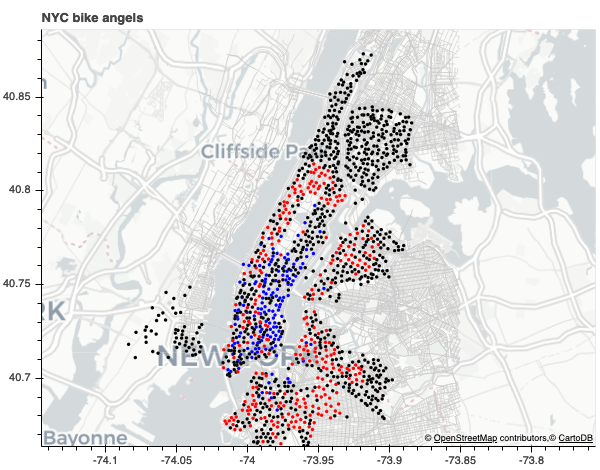